In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import numpy as np
from PanStitch import *

## 1. Input

### Image Setting

In [2]:
xsize, ysize = 10200,6800 # x, y size of the image
pixscale = 0.505 # pixel scale [arcsec / pixel]

### OBJECT (TILE) to Stitch

In [3]:
obj = 'T12400'
cra, cdec = 116.34980988593155,-20.377358490566035
filte = 'r'

### Pointing Grid

In [4]:
# n, m = 2, 1
n, m = 8, 4
margin_frac = 0.1
ps1size = 6000
n_retry = 3
nthreads = 8

### Path

In [5]:
path_output = f'./output/{filte}'
path_slice = f'{path_output}/ps1_slice'
path_outim = f'{path_output}/ref_PS1_{obj}_00000000_000000_{filte}_0.fits'

#	SWarp
path_swarp_conf = './conf/7dt.swarp'
list_file_path = './output/images_to_stitch.txt'

In [6]:
os.makedirs(path_output, exist_ok=True)
os.makedirs(path_slice, exist_ok=True)

## 2. Pointing Grid

In [7]:
pointings = generate_pointings(cra, cdec, xsize, ysize, pixscale, n=n, m=m, margin_frac=margin_frac)

Plot saved to ./output/r/ps1_query_pointing_T12400_r.png


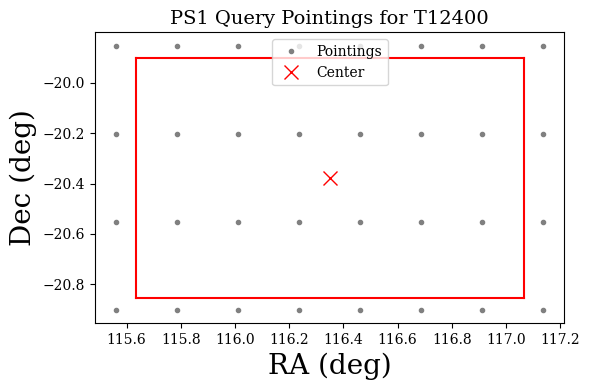

In [8]:
output_plot_path = f"{path_output}/ps1_query_pointing_{obj}_{filte}.png"
plot_pointings_on_sky(pointings, cra, cdec, xsize, ysize, pixscale, output_plot_path, title=f"PS1 Query Pointings for {obj}")

In [9]:
# Grid and download images
tdec = np.array([])
tra = np.array([])

tra = np.array([val[0] for val in pointings])
tdec = np.array([val[1] for val in pointings])

In [10]:
t0 = time.time()
tab = getimages(tra, tdec, filters=filte, size=6000)  # Keep the size no bigger than 6000 pixels
print(f"{time.time() - t0:.1f} s: got list of {len(tab)} images for {len(tra)} positions")
tab.sort(['projcell', 'subcell', 'filter'])
tab[:3]

1.1 s: got list of 32 images for 32 positions


projcell,subcell,ra,dec,filter,mjd,type,filename,shortname,badflag,url
int64,int64,float64,float64,str1,float64,str5,str70,str43,int64,str190
823,71,117.13676821926488,-20.901997379454922,r,0.0,stack,/rings.v3.skycell/0823/071/rings.v3.skycell.0823.071.stk.r.unconv.fits,rings.v3.skycell.0823.071.stk.r.unconv.fits,0,https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?size=6000&format=fits&ra=117.13676821926488&dec=-20.901997379454922&red=/rings.v3.skycell/0823/071/rings.v3.skycell.0823.071.stk.r.unconv.fits
823,72,116.91192298116964,-20.901997379454922,r,0.0,stack,/rings.v3.skycell/0823/072/rings.v3.skycell.0823.072.stk.r.unconv.fits,rings.v3.skycell.0823.072.stk.r.unconv.fits,0,https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?size=6000&format=fits&ra=116.91192298116964&dec=-20.901997379454922&red=/rings.v3.skycell/0823/072/rings.v3.skycell.0823.072.stk.r.unconv.fits
823,72,116.68707774307441,-20.901997379454922,r,0.0,stack,/rings.v3.skycell/0823/072/rings.v3.skycell.0823.072.stk.r.unconv.fits,rings.v3.skycell.0823.072.stk.r.unconv.fits,0,https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?size=6000&format=fits&ra=116.68707774307441&dec=-20.901997379454922&red=/rings.v3.skycell/0823/072/rings.v3.skycell.0823.072.stk.r.unconv.fits


## 4. Downloading

In [11]:
image_files = download_images_for_pointings(tab, path_slice, n_retry=n_retry)

print(image_files)

[00] 0.0 s: Downloading missing image: t117.1368-20.9020.r.fits-->Done!
[01] 0.0 s: Downloading missing image: t116.9119-20.9020.r.fits-->Done!
[02] 0.0 s: Downloading missing image: t116.6871-20.9020.r.fits-->Done!
[03] 0.0 s: Downloading missing image: t116.4622-20.9020.r.fits-->Done!
[04] 0.0 s: Downloading missing image: t116.2374-20.9020.r.fits-->Done!
[05] 0.0 s: Downloading missing image: t116.0125-20.9020.r.fits-->Done!
[06] 0.0 s: Downloading missing image: t115.7877-20.9020.r.fits-->Done!
[07] 0.0 s: Downloading missing image: t115.5629-20.9020.r.fits-->Done!
[08] 0.0 s: Downloading missing image: t117.1368-20.5522.r.fits-->Done!
[09] 0.0 s: Downloading missing image: t116.6871-20.5522.r.fits-->Done!
[10] 0.0 s: Downloading missing image: t116.9119-20.5522.r.fits-->Done!
[11] 0.0 s: Downloading missing image: t116.4622-20.5522.r.fits-->Done!
[12] 0.0 s: Downloading missing image: t116.2374-20.5522.r.fits-->Done!
[13] 0.0 s: Downloading missing image: t115.7877-20.5522.r.fits-

## 5. Run `SWarp` - Stitching

In [12]:
write_images_to_swarp(list_file_path, image_files)

./output/images_to_stitch.txt generated


In [13]:
path_outim

'./output/r/ref_PS1_T12400_00000000_000000_r_0.fits'

In [14]:
center_ra_hms, center_dec_dms = degrees_to_hms_dms(cra, cdec)

run_swarp(
	list_file_path, 
	path_outim, 
	path_swarp_conf, 
	center_ra_hms, 
	center_dec_dms, 
	xsize=xsize, ysize=ysize, 
	nthreads=nthreads
	)

print(f"Process completed. Stacked image saved to: {path_outim}")

swarp @./output/images_to_stitch.txt -c ./conf/7dt.swarp -IMAGEOUT_NAME ./output/r/ref_PS1_T12400_00000000_000000_r_0.fits -WEIGHTOUT_NAME ./output/r/ref_PS1_T12400_00000000_000000_r_0.weight.fits -CENTER "07:45:24,-20:22:38.4906" -IMAGE_SIZE 10200,6800 -NTHREADS 8 


----- SWarp 2.41.5 started on 2024-10-02 at 23:31:38 with 8 threads

------- Output File ref_PS1_T12400_00000000_000000_r_0.fits:
    "no ident"  WEIGHTED  no ext. header  10200x6800  32 bits (floats)
    Center: 07:45:24.18 -20:22:38.1   85.9'x57.2'  Scale: 0.505 ''/pixel
    Gain: 0 e-/ADU   Flux scaling (astrom/photom): 1 X / 1 X

-------------- File t117.1368-20.9020.r.fits:
    "no ident"  unweighted  no ext. header  6000x6000  32 bits (floats)
    Center: 07:48:32.84 -20:54:07.4   25'x25'  Scale: 0.2498 ''/pixel
    Gain: 0.78 e-/ADU   Flux scaling (astrom/photom): 4.084 X / 1 X
    Background: -13.17948   RMS: 130.7464

-------------- File t116.9119-20.9020.r.fits:
    "no ident"  unweighted  no ext. header  6000x6000  32 bits (floats)
    Center: 07:47:38.87 -20:54:07.3   25'x25'  Scale: 0.2499 ''/pixel
    Gain: 0.78 e-/ADU   Flux scaling (astrom/photom): 4.084 X / 1 X
    Background: -16.71735   RMS: 162.7168

-------------- File t116.6871-20.9020.r.fits:
    "no ident"  unwe

Process completed. Stacked image saved to: ./output/r/ref_PS1_T12400_00000000_000000_r_0.fits


> All done (in 38.8 s)
